## Barotropic streamfunction
Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy as sp
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
#cc.start_cluster()
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34524 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average from 1998 onwards, aiming for the average of the streamfunction over the concurrent period of the simulation, following 0.1° spinup.

In [4]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cntrl_tx_trans = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                                        n=n_files,time_units=time_units, offset=offset)\
                                        .sel(time=slice(pd.datetime(1998,1,1),None)).mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts
    
    return gyre_psi

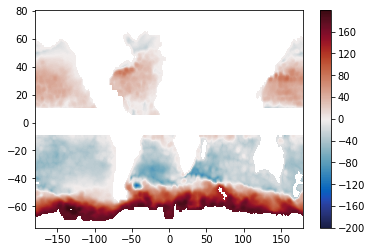

In [5]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

In [13]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


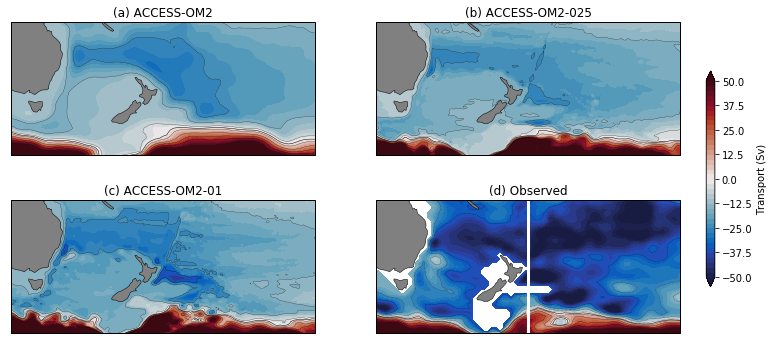

In [17]:
# EAC Region
plt.figure(figsize(12,6))
clev = np.arange(-50,50.01,2.5)
clev2 = np.arange(-35,35.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-220, -140, -55, -20], crs=ccrs.PlateCarree())
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])


ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-220, -140, -55, -20], crs=ccrs.PlateCarree())
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Observed')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('eac_barotropic_streamfunctions')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


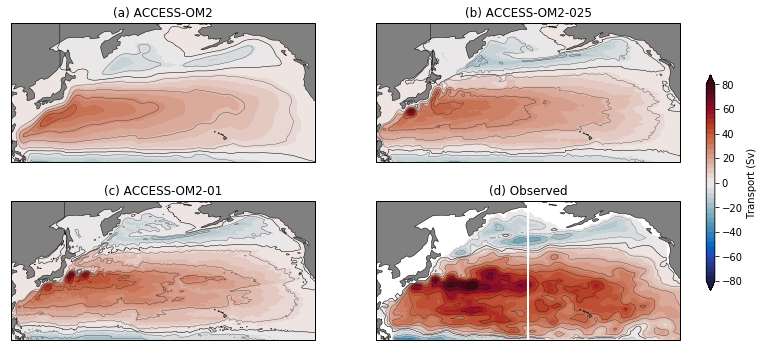

In [14]:
# Kuroshio Region
plt.figure(figsize(12,6))
clev = np.arange(-80,80.01,5)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])


ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Observed')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('kuroshio_barotropic_streamfunctions')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


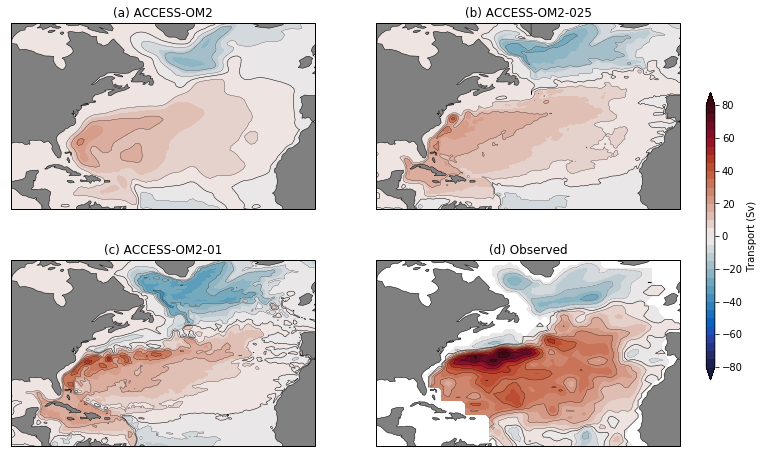

In [15]:
# Gulf Stream Region
plt.figure(figsize(12,8))
clev = np.arange(-80,80.01,5)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])


ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Observed')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gulfstream_barotropic_streamfunctions')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


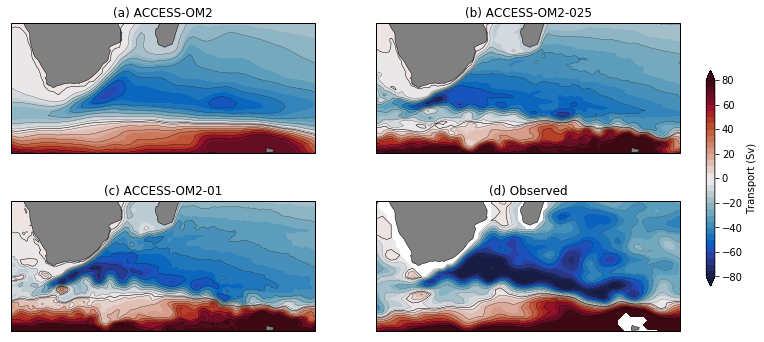

In [16]:
# Agulhas Region
plt.figure(figsize(12,6))
clev = np.arange(-80,80.01,5)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])


ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Observed')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('agulhas_barotropic_streamfunctions')

In [ ]:
def global_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-160,160.01,2)
    clev2 = np.arange(-140,140.01,10)
    
    map = Basemap(projection='mbtfpq',lon_0 = -100,resolution='l')
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-60.,61.,30.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(-180.,181.,90.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def agulhas_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)
    
    map = Basemap(llcrnrlon=10,llcrnrlat=-50,urcrnrlon=79.9,urcrnrlat=-20,
             resolution='l', projection='cyl', lat_0 = 35, lon_0 = -35)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-50.,-20.,10.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(0.,81.,20.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t,geolat_t)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def kuroshio_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-240,urcrnrlon=-120,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def gulfstream_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-95,urcrnrlon=-5,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [ ]:
def eac_map_psi(gyre_psi,geolon,geolat):
    clev = np.arange(-30,30.01,1)
    clev2 = np.arange(-25,25.01,5)
    
    map = Basemap(projection='cyl',llcrnrlat=-55,urcrnrlat=-20,\
            llcrnrlon=-220,urcrnrlon=-140,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

## Plot gyre transport, with DP transport subtracted

This is the plot designed for the model evaluation paper.

In [ ]:
%%time
plt.figure(1,figsize(8,12))
plt.figure(2,figsize(12,6))
plt.figure(3,figsize(12,6))
plt.figure(4,figsize(12,8))
plt.figure(5,figsize(12,6))

plot_labels=['(a) ','(b) ','(c) ']

#for i, ekey in enumerate(exptdata.exptdict.keys()):
for i, ekey in enumerate(['1deg']):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    geolon_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolon_t',n=1).mean('time')
    geolat_t = cc.get_nc_variable(expt,'ocean_grid.nc','geolat_t',n=1).mean('time')
    
    label=plot_labels[i]
    
    plt.figure(1)
    plt.subplot(3,1,i+1)
    p1 =global_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(2)
    plt.subplot(2,2,i+1)
    p2 =agulhas_map_psi(gyre_psi,geolon_t.values,geolat_t.values)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(3)
    plt.subplot(2,2,i+1)
    p3 = kuroshio_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(4)
    plt.subplot(2,2,i+1)
    p4 = gulfstream_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(5)
    plt.subplot(2,2,i+1)
    p5 = eac_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
plt.figure(1)
ax3 = plt.axes([0.92,0.35,0.02,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('global_barotropic_streamfunctions')

plt.figure(2)
subplot(224)
agulhas_map_psi(psi,lon,lat)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p2,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('agulhas_barotropic_streamfunctions')

plt.figure(3)
subplot(224)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p3,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('kuroshio_barotropic_streamfunctions')

plt.figure(4)
subplot(224)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.3,0.01,0.4])
cb = plt.colorbar(p4,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gulfstream_barotropic_streamfunctions')

plt.figure(5)
subplot(224)
plt.title('(d) Observations')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p5,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('eac_barotropic_streamfunctions')

# Below here, plots are old, not maintained.

------------

## Plot ACC transport

In [ ]:
levels = np.linspace(-200,200,21)

plt.figure(figsize(9.5,12))

plt.subplot(1,1,1)
# map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map = Basemap(projection ='spstere',boundinglat=-25,lon_0=-150,resolution='l',round=True)
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-90.,91.,15.),linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[0,0,0,0],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=levels, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(-200,200,20)
# print clev3
map.contour(X,Y,gyre_psi,levels=clev3,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('mean ACC barotropic streamfunction, ' + ekey)

ax3 = plt.axes([0.15,0.15,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')

savefigure('ACC_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 9:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f9.jpeg)

## Plot Kuroshio transport, with DP transport subtracted

In [ ]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,10)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-250,urcrnrlon=-90,resolution='l') # WARNING: includes tripole region north of 65N
map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.PiYG, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
plt.title('mean Kuroshio barotropic streamfunction, ' + ekey)

ax3 = plt.axes([0.15,0.25,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('Kuroshio_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 7:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f7.jpeg)

## Plot Gulf Stream transport, with DP transport subtracted

In [ ]:
# gyre_psi = -cntrl_psi+cntrl_dp_ts

plt.figure(figsize(9.5,12))
levels = np.linspace(-200,200,21)
clev = np.arange(-90,90.1,2)
clev2 = np.arange(-90,90.1,5)

plt.subplot(1,1,1)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=70,\
            llcrnrlon=-90,urcrnrlon=0,resolution='l') # WARNING: includes tripole region north of 65N
#map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
X, Y = map(geolon_t.values,geolat_t.values) 
# p1=map.contourf(X,Y,cntrl_psi, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
p1=map.contourf(X,Y,gyre_psi, cmap=plt.cm.seismic, levels=clev, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
# print clev3
# map.contour(X,Y,gyre_psi,levels=clev3,colors='g',linewidths=1)
map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
# plt.title('Barotropic streamfunction')
plt.title('mean Gulf Stream barotropic streamfunction, ' + ekey)

ax3 = plt.axes([0.15,0.1,.7,0.015])
cb = plt.colorbar(p1,cax=ax3,orientation='horizontal')
cb.ax.set_xlabel('Transport (Sv)')
savefigure('GulfStream_transport_'+ekey)

cf. [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1) fig 3:

![](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2016/15200485-46.1/jpo-d-15-0046.1/20160222/images/large/jpo-d-15-0046.1-f3.jpeg)